In [156]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.io import loadmat
from numpy.linalg import det, inv
from math import sqrt, pi
import scipy.io
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import seaborn as sns
from sklearn.model_selection import train_test_split

In [157]:
dt = pd.read_csv('fill_with_mean_data.csv', sep=",")

In [158]:
dt['Sector_fac'] = pd.factorize(dt['Sector'])[0]

In [159]:
pd.factorize(dt['Sector'])[0]

array([0, 1, 2, ..., 6, 2, 6])

In [160]:
sector_index = pd.factorize(dt['Sector'])[1]

In [161]:
sector_index

Index(['Financial Services', 'Healthcare', 'Industrials', 'Consumer Defensive',
       'Basic Materials', 'Consumer Cyclical', 'Energy', 'Technology',
       'Communication Services', 'Utilities', 'Real Estate'],
      dtype='object')

In [162]:
sector_dict = {k: v for v, k in enumerate(sector_index)}

In [163]:
dt0 = dt[dt['Class'] == 0]
dt1 = dt[dt['Class'] == 1]
new_dt0 = dt0.sample(n = dt1.shape[0], replace = True)

In [164]:
new_dt = pd.concat([new_dt0, dt1], axis = 0)

In [165]:
X = new_dt.values[:, 3:]

In [166]:
Y = new_dt.values[:, 1].astype('int')

In [167]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 100)

In [168]:
def LinearRegressionModel(X, y, with_fit_intercept):
    # Inputs:                                                                   
    # X = N x d, d means the number of features/attributes                                                              
    # y = N x 1                                                                 
    # Output:                                                                   
    # Linear regression model
    clf = LinearRegression(fit_intercept=with_fit_intercept).fit(X, y)
    # IMPLEMENT THIS METHOD USING sklearn.linear_model.LinearRegression. 
    # By default, fit_intercept=True, but in this problem, you need to assign a value with_fit_intercept to fit_intercept.
    
    return clf

In [169]:
def learnOLERegression(X,y):
    # Inputs:                                                                   
    # X = N x d, d means the number of features/attributes                                                                 
    # y = N x 1                                                                 
    # Output:                                                                   
    # w = d x 1                                                                 
    Xt = np.transpose(X)              
    dot1 = np.dot(Xt,X)                
    inverse = inv(dot1)                
    w = np.dot(inverse, np.dot(Xt,y)) 
    
    X_T = np.transpose(X)
    X_T_X = np.dot(X_T, X)
    
    w = np.dot(np.dot(inv(X_T_X), X_T), y)
    # IMPLEMENT THIS METHOD, please refer to the sample code named 'lecture_6.ipynb'
    
    return w

In [170]:
def testOLERegression(w,Xtest,ytest):
    # Inputs:
    # w = d x 1, d means the number of features/attributes
    # Xtest = N x d, d means the number of features/attributes
    # ytest = X x 1
    # Output:
    # mse
    
    f1 = np.dot(Xtest, w)
    f2 = ytest - f1
    f3 = np.transpose(f2)
    f4 = np.dot(f3, f2)
    
    N = Xtest.shape[0]
    
    mse = f4 / N
    # IMPLEMENT THIS METHOD
    
    return mse

In [171]:
def learnRidgeRegression(X,y,lambd):
    # Inputs:                                                                   
    # X = N x d, d means the number of features/attributes                                                                 
    # y = N x 1 
    # lambd = ridge parameter (scalar)
    # Output:                                                                   
    # w = d x 1                                                                 

    # IMPLEMENT THIS METHOD. 
    # This function is similar to 'learnOLERegression'. 
    # The difference is that we need to add an identity matrix with X_T_X.
    I_matrix = np.eye(X.shape[1]) # this is the identity matrix
    
    f1 = np.transpose(X)
    f2 = np.dot(f1, X)

    n_col = X.shape[1]

    f3 = lambd * I_matrix

    f4 = inv(f2 + f3)

    f5 = np.dot(f4, np.transpose(X))

    w = np.dot(f5, y)
    
    return w

In [172]:
def RidgeRegressionModel(X, y, alpha_value):
    # Inputs:                                                                   
    # X = N x d, d means the number of features/attributes                                                                 
    # y = N x 1                                                                 
    # Output:                                                                   
    # Linear regression model
    clf = Ridge(alpha=alpha_value).fit(X,y)
    # IMPLEMENT THIS METHOD USING sklearn.linear_model.Ridge
     
    return clf

In [173]:
def mapNonLinear(x,p):
    # Inputs:                                                                   
    # x - a single column vector (N x 1)                                        
    # p - integer (>= 0)                                                        
    # Outputs:                                                                  
    # The shape of Xd is (N x (d+1))                                                      
    
    # IMPLEMENT THIS METHOD
    Xd = np.zeros((x.shape[0],p+1)) # initialize matrix
    for i in range(p+1):
        Xd[:, i] = np.power(x, i)
        # FILL IN: assign values to each columun Xd[:,i]
    
    return Xd

In [174]:
def regressionObjVal(w, X, y, lambd):
    # this function is only used for Problem 5!
    # compute squared error (scalar) and gradient of squared error with respect
    # to w (vector) for the given data X and y and the regularization parameter
    # lambda                                                                  
    
    # IMPLEMENT THIS METHOD 
    w = np.transpose(np.asmatrix(w))
    
    # fill in 
    Xw = np.dot(X,w)
    f1 = np.transpose(y-Xw)
    f2 = y-Xw
    f3 = np.dot(f1,f2)
    wt= np.transpose(w)
    ww = np.dot(wt,w)
    f4 = np.dot(lambd,ww)
    f5 = f3+f4
    
    Xt = np.transpose(X)
    X2 = -2 * Xt
    f6 = np.dot(X2,f2)
    f7 = np.dot(lambd, w)
    f8 = 2 * f7
    f9 = f6 + f8
    
    error = f5# (y-Xw)^T(y-Xw) + lambda * w^Tw
    error_grad = f9# -2*X^T(y-Xw) + 2*lambda*w
    
    error_grad = np.squeeze(np.array(error_grad))
    return error, error_grad

In [175]:
x_train = x_train.astype(float)

In [176]:
new_y_train = []
for values in y_train:
    new_list = []
    new_list.append(values)
    new_y_train.append(new_list)
    
y_train = np.array(new_y_train, dtype = 'int')

In [185]:
new_y_test = []
for values in y_test:
    new_list2 = []
    new_list2.append(values)
    new_y_test.append(new_list2)
    
y_test = np.array(new_y_test, dtype = 'int')

In [186]:
y_test

array([[1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
    

In [187]:
# Main script

# Problem 1
# Input data
X = x_train
y = y_train
Xtest = x_test
ytest = y_test   
# add intercept
x1 = np.ones((len(X),1))
x2 = np.ones((len(Xtest),1))

X_i = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
Xtest_i = np.concatenate((np.ones((Xtest.shape[0],1)), Xtest), axis=1)


# Scikit package
clf_without_intercept = LinearRegressionModel(X, y, False)
w_lr = clf_without_intercept.coef_[0]
w_lr = w_lr.reshape((len(w_lr), 1))
mle_lr = testOLERegression(w_lr,Xtest,ytest)
print('Sklearn MSE without intercept '+str(mle_lr))

clf_with_intercept = LinearRegressionModel(X, y, True)
w_i_lr = np.concatenate((clf_with_intercept.intercept_, clf_with_intercept.coef_[0]), axis = 0)
w_i_lr = w_i_lr.reshape((len(w_i_lr), 1))
mle_i_lr = testOLERegression(w_i_lr,Xtest_i,ytest)
print('Sklearn MSE with intercept '+str(mle_i_lr))

# Matrix computation 
w = learnOLERegression(X,y)
mle = testOLERegression(w,Xtest,ytest)

w_i = learnOLERegression(X_i,y)
mle_i = testOLERegression(w_i,Xtest_i,ytest)

print('OLE MSE without intercept '+str(mle))
print('OLE MSE with intercept '+str(mle_i))

Sklearn MSE without intercept [[0.2998797392798858]]
Sklearn MSE with intercept [[0.24272504391074592]]
OLE MSE without intercept [[0.2998797392798857]]
OLE MSE with intercept [[0.24272504391074642]]


The smallest Sklearn MSE: 0.24271854170163978
The corresponding alpha for Sklearn: 1.0
The smallest OLE MSE: 0.24270763311437563
The corresponding alpha for OLE: 1.0


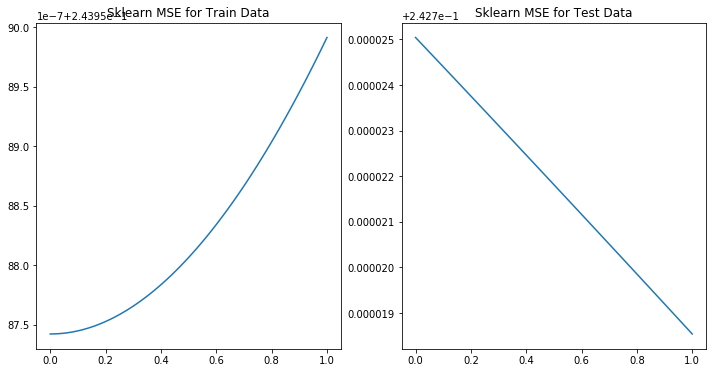

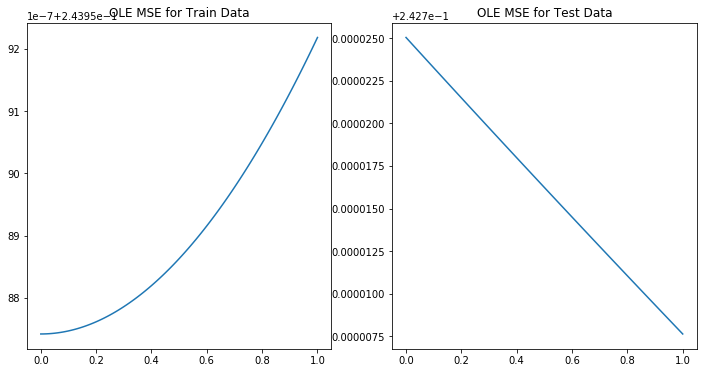

In [188]:
# Problem 2
k = 101
alphas = np.linspace(0, 1, num=k)
i = 0
mses2_train_rr = np.zeros((k,1))
mses2_rr = np.zeros((k,1))
for alpha in alphas:
    clf = RidgeRegressionModel(X,y,alpha)
    w_l_rr = np.concatenate((clf.intercept_, clf.coef_[0]), axis = 0)
    w_l_rr = w_l_rr.reshape((len(w_l_rr), 1))
    mses2_train_rr[i] = testOLERegression(w_l_rr,X_i,y)
    mses2_rr[i] = testOLERegression(w_l_rr,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(alphas,mses2_train_rr)
plt.title('Sklearn MSE for Train Data')
plt.subplot(1, 2, 2)
plt.plot(alphas,mses2_rr)
plt.title('Sklearn MSE for Test Data')

# mses2_rr represents the errors on the testing data of different alpha's 
# 1. obtain the smallest mse
min_mse_sklearn = np.min(mses2_rr)
print('The smallest Sklearn MSE:', min_mse_sklearn)
# 2. obtain the index of the smallest mse
index_min_mse_sklearn = np.argmin(mses2_rr)
# 3. obtain the corresponding alpha
min_alpha_sklearn = alphas[index_min_mse_sklearn]
print('The corresponding alpha for Sklearn:', min_alpha_sklearn)

i = 0
mses2_train = np.zeros((k,1))
mses2 = np.zeros((k,1))
for alpha in alphas:
    w_l = learnRidgeRegression(X_i,y,alpha)
    mses2_train[i] = testOLERegression(w_l,X_i,y)
    mses2[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(alphas,mses2_train)
plt.title('OLE MSE for Train Data')
plt.subplot(1, 2, 2)
plt.plot(alphas,mses2)
plt.title('OLE MSE for Test Data')

# mses2 represents the errors on the testing data of different alpha's 
# 1. obtain the smallest mse
min_mse_ole = np.min(mses2)
print('The smallest OLE MSE:', min_mse_ole)
# 2. obtain the index of the smallest mse
index_min_mse_ole = np.argmin(mses2)
# 3. obtain the corresponding alpha
min_alpha_ole = alphas[index_min_mse_ole]
print('The corresponding alpha for OLE:', min_alpha_ole)


Training errors of linear models without using the regularization term:
p = 0 training error = 0.25
p = 1 training error = 0.2497518406756111
p = 2 training error = 0.24964073447122112
p = 3 training error = 0.2496405822844944
p = 4 training error = 0.24916446112032417
p = 5 training error = 0.24867043538915326
p = 6 training error = 1.7162626314429268
Training errors of linear models using the regularization term:
p = 0 training error = 0.2500001058259738
p = 1 training error = 0.24975194640430387
p = 2 training error = 0.24964084037921955
p = 3 training error = 0.2496406922303521
p = 4 training error = 0.24916459651971765
p = 5 training error = 0.24867053347511928
p = 6 training error = 3.5004547541143154
Testing errors of linear models without using the regularization term:
p = 0 testing error = 0.25000000000000006
p = 1 testing error = 0.25002520498806985
p = 2 testing error = 0.2501146444438301
p = 3 testing error = 0.2501286044932272
p = 4 testing error = 0.24863131023834276
p = 

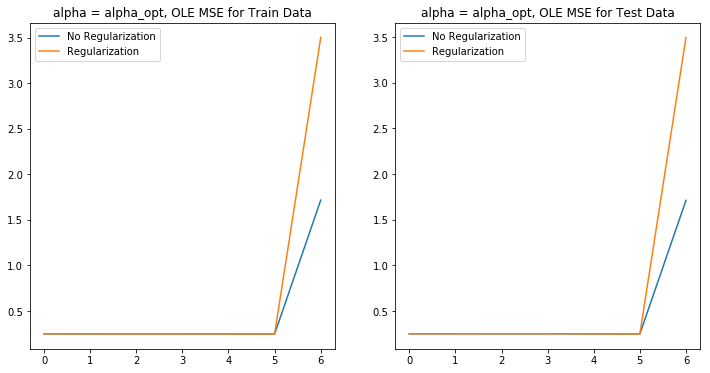

In [189]:
# Problem 3
pmax = 7
alpha_opt = alphas[np.argmin(mses2)]
mses3_train = np.zeros((pmax,2))
mses3 = np.zeros((pmax,2))
for p in range(pmax):
    Xd = mapNonLinear(X[:,2],p)
    Xdtest = mapNonLinear(Xtest[:,2],p)
    w_d1 = learnRidgeRegression(Xd,y,0) # alpha = 0
    mses3_train[p,0] = testOLERegression(w_d1,Xd,y)
    mses3[p,0] = testOLERegression(w_d1,Xdtest,ytest)
    w_d2 = learnRidgeRegression(Xd,y,alpha_opt) # alpha = alpha_opt
    mses3_train[p,1] = testOLERegression(w_d2,Xd,y)
    mses3[p,1] = testOLERegression(w_d2,Xdtest,ytest)
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(range(pmax),mses3_train)
plt.title('alpha = alpha_opt, OLE MSE for Train Data')
plt.legend(('No Regularization','Regularization'))

plt.subplot(1, 2, 2)
plt.plot(range(pmax),mses3)
plt.title('alpha = alpha_opt, OLE MSE for Test Data')
plt.legend(('No Regularization','Regularization'))

# print the training erros for different p's
# the first columun means the errors of linear models without using the regularization term
print('Training errors of linear models without using the regularization term:')
for i in range(pmax):
    print('p =',i, 'training error =', mses3_train[i][0])
# the second columun means the errors of linear models using the regularization term

print('Training errors of linear models using the regularization term:')
for i in range(pmax):
    print('p =',i, 'training error =', mses3_train[i][1])

# print the testing erros for different p's
# the first columun means the errors of linear models without using the regularization term
print('Testing errors of linear models without using the regularization term:')
for i in range(pmax):
    print('p =',i, 'testing error =', mses3[i][0])
# the second columun means the errors of linear models using the regularization term

print('Testing errors of linear models using the regularization term:')
for i in range(pmax):
    print('p =',i, 'testing error =',mses3[i][1])